Loading the modules

In [50]:
# MALA itself.

import mala

# We would like to visualize simple plots.
# The font size can sometimes be a bit small for Jupyter Notebooks.

import matplotlib
import matplotlib.pyplot as plt
font = {'size'   : 22}
matplotlib.rc('font', **font)

# For the data paths.
from os.path import join as pj

# Only for the prediction down below.
from ase.io import read

# To do some timings down below.
from time import time
import numpy as np
import mala
import subprocess
import ase
import ase.io.espresso
from ase import Atoms
from ase.visualize import view
import os
from os.path import join as pj
import matplotlib.pyplot as plt
import re
import random
import time

MALA data generation can be performed with the Quantum ESPRESSO package. Some changes to this open source package were necessary to enable the correct sampling of the LDOS. The current development branch of Quantum ESPRESSO includes those - beginning with Quantum ESPRESSO version 7.2 (to be released in ~June 2023) users can simply download the latest QE version and perform data generation.

Data generation is two-fold: First, one creates a set of atomic position via a regular DFT-MD simulation at the conditions of interest. This can be done with any suitable code, such as VASP, QE, etc. Secondly, one performs DFT simulations to access the LDOS.

The test system  here will be a simply beryllium system at room temperature consisting of 2 beryllium atoms. Atomic configurations have been sampled beforehand. We will start with the DFT simulation. 

Write hundreds of lines of parameter statement in each python script is not exactly maintainable. Therefore MALA provides a .json interface.


In [51]:
parameters = mala.Parameters.load_from_file("mala_parameters_01.json")

In [52]:
parameters.show()

---     All parameter MALA needs to perform its various tasks. ---
comment        : My first parameters.
manual_seed    : None
use_gpu        : True
device         : cuda:0
use_horovod    : False
use_mpi        : False
verbosity      : 1
openpmd_configuration: {}
openpmd_granularity: 1
use_lammps     : True
---     Parameters necessary for constructing a neural network. ---
	nn_type        : feed-forward
	layer_sizes    : [10, 10, 10]
	layer_activations: ['Sigmoid']
	loss_function_type: mse
	num_hidden_layers: 1
	no_hidden_state: False
	bidirection    : False
	dropout        : 0.1
	num_heads      : 10
---     Parameters necessary for calculating/parsing input descriptors. ---
	descriptor_type: Bispectrum
	lammps_compute_file: 
	descriptors_contain_xyz: True
	use_z_splitting: True
	number_y_planes: 0
	bispectrum_twojmax: 10
	rcutfac        : 4.67637
	atomic_density_cutoff: 4.67637
	snap_switchflag: 1
	use_atomic_density_energy_formula: False
	atomic_density_sigma: None
	minterpy_point_l

In [72]:
data_path = r"C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be"
snapshot_path =  r"C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots"

We'll now convert the data to MALA DATA (maxiter must be the same as QE files) 
THIS WILL TAKE LONG AS FUCK because no LAMMPS, be warned. There is a multiproccesing script in Github

In [73]:
data_converter = mala.DataConverter(parameters)
maxiter = 8
for i in range(1, maxiter):
    time1 = time.time()
    data_converter.add_snapshot(descriptor_input_type="espresso-out",
                                descriptor_input_path=os.path.join(data_path,f"Be{i}.pw.out"),
                                target_input_type=".cube",
                                target_input_path=os.path.join(f"tmp.pp0*Be{i}_ldos.cube"))
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")
print("CONVERTING SNAPSHOTS")
time1 = time.time()
data_converter.convert_snapshots("./snapshots/", naming_scheme="Be_snapshot*.npy")


DONE ADDING DATA ITERATION 1 of 7 in 0.00s
DONE ADDING DATA ITERATION 2 of 7 in 0.00s
DONE ADDING DATA ITERATION 3 of 7 in 0.00s
DONE ADDING DATA ITERATION 4 of 7 in 0.00s
DONE ADDING DATA ITERATION 5 of 7 in 0.00s
DONE ADDING DATA ITERATION 6 of 7 in 0.00s
DONE ADDING DATA ITERATION 7 of 7 in 0.00s
CONVERTING SNAPSHOTS
Calculating descriptors from C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\Be1.pw.out
No LAMMPS found for descriptor calculation, falling back to python.
Using python for descriptor calculation. The resulting calculation will be slow for large systems.



KeyboardInterrupt



Visualizing and reproducing output data

Before we train a model, it is a good idea to think about which metric is important, i.e., how do we test if a model is good?

In essence, the advantage of MALA is the access to multiple observables. Two easily accesible metrics are the density of states (DOS) and the band energy. We will now learn how to calculate them from the LDOS (the actual DFT LDOS in this case) so we can do the same after model training to test our models.

For this, we first have to make sure the correct LDOS parameters are used.


In [74]:
parameters.targets.target_type = "LDOS"
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5

Now we can create an LDOS calculator and directly populate it with the LDOS data from the data set.

In [85]:
ldos_calculator = mala.LDOS.from_numpy_file(parameters, pj(snapshot_path, "Be_snapshot1.out.npy"))


Afterwards, we have to read in some additional information from the simulation data (size of the real space grid, temperature, etc.).

In [86]:
ldos_calculator.read_additional_calculation_data(pj(data_path, "Be1.pw.out"))
print(ldos_calculator.density_of_states)
print(ldos_calculator.energy_grid)
#print(ldos_calculator.density_of_states)

[0.30867848 0.40815389 0.50501234 0.58352213 0.63074861 0.63961693
 0.60908288 0.54389667 0.45474118 0.35631671 0.26284809]
[-5.  -2.5  0.   2.5  5.   7.5 10.  12.5 15.  17.5 20. ]


Now we can access the DOS and the band energy as properties of the calculator object.

-4.613344314276244


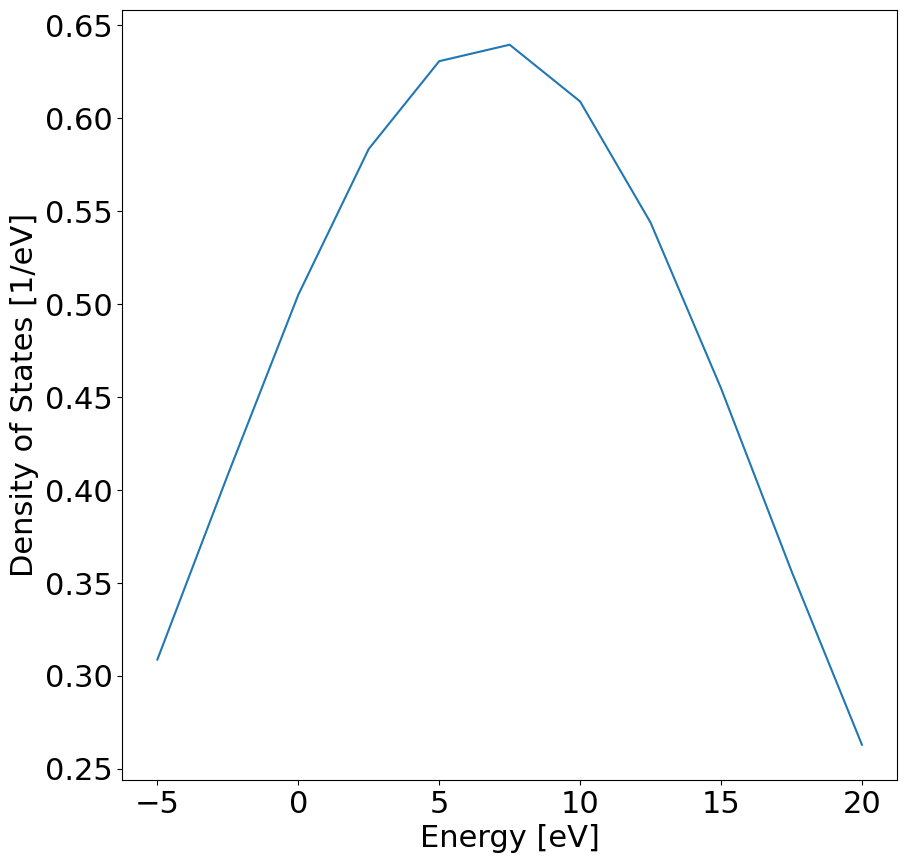

In [87]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states)

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")

print(ldos_calculator.band_energy)

In [123]:
parameters.verbosity = 2
parameters.manual_seed = 2024

Now we have to add data, we have to choose between training and test data

In [129]:
prop = 0.6
prop2 = 0.2
maxiter = 8
def split_data(data):
    random.shuffle(data)  # Shuffle the data randomly
    split_80 = int(len(data) * prop)  # Calculate the index for the 80% split
    split_20 = int(len(data) * prop2)  # Calculate the index for the 20% split
    train_data = data[:split_80]  # Extract the first 80% of the shuffled data
    test_data = data[split_80:split_80+split_20 + 2]  # Extract the next 20% of the shuffled data
    validation_data = data[split_80+split_20:]  # Extract the remaining 20% of the shuffled data
    return train_data, test_data, validation_data
    
indexes = np.arange (1,maxiter +1)
train_data, test_data, validation_data = split_data(indexes)
print(train_data, test_data, validation_data )

[6 3 1 8] [5 2 4] [2 4 7]


In [130]:
data_handler = mala.DataHandler(parameters)

for i in range(1, maxiter + 1):
    time1 = time.time()
    if i in train_data:
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "tr")
    elif i in validation_data :
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "va")
    else:
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Be{i}.pw.out"))
    print(f"DONE ADDING DATA ITERATION {i} of {maxiter - 1} in {time.time() - time1:.2f}s")

# This already loads data into RAM!
data_handler.prepare_data()
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  100,
                                  data_handler.output_dimension]

No data rescaling will be performed.
No data rescaling will be performed.
DONE ADDING DATA ITERATION 1 of 7 in 0.00s
DONE ADDING DATA ITERATION 2 of 7 in 0.00s
DONE ADDING DATA ITERATION 3 of 7 in 0.00s
DONE ADDING DATA ITERATION 4 of 7 in 0.00s
DONE ADDING DATA ITERATION 5 of 7 in 0.00s
DONE ADDING DATA ITERATION 6 of 7 in 0.00s
DONE ADDING DATA ITERATION 7 of 7 in 0.00s
DONE ADDING DATA ITERATION 8 of 7 in 0.00s
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot1.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot1.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking descriptor file  Be_snapshot2.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot2.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\

Now we  can train the Network

In [132]:
parameters.running.max_number_epochs = 5
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()

batch 1000, validation avg time: 0.0008132367134094238 validation avg throughput: 12296.542734864826
batch 2000, validation avg time: 0.0008361880779266357 validation avg throughput: 11959.032021594268
Initial Guess - validation data loss:  0.2358542238809042
Initial Guess - test data loss:  0.23817811754014756
batch 1000, train avg time: 0.0019230849742889404 train avg throughput: 5199.97822961385
batch 2000, train avg time: 0.0019225785732269287 train avg throughput: 5201.347887288487
batch 3000, train avg time: 0.0019070737361907958 train avg throughput: 5243.635739000883
training time: 7.150609493255615
batch 1000, validation avg time: 0.0008702895641326904 validation avg throughput: 11490.428487403222
batch 2000, validation avg time: 0.0007527005672454834 validation avg throughput: 13285.4955013454
Epoch 0: validation data loss: 3.053236712088565e-05, training data loss: 0.0002552136978578951
Time for epoch[s]: 9.338724613189697
batch 1000, train avg time: 0.0018810908794403077 tr

We can test this by using the Tester class. The class works similar to the Trainer class. We add data, push them through the model, and then use the results to perform calculations.

We just have to make sure that the LDOS is correctly integrated by setting the appropriate parameters. Then we can add data to test. We should always test on data different from the one we trained on. Also, we now have to specify the corresponding calculation output, since we may need this for integration.

In [133]:
"""data_handler.clear_data()
for i in range(1, maxiter + 1):
    if i in test_data:
        data_handler.add_snapshot(f"Be_snapshot{i}.in.npy", snapshot_path,
                              f"Be_snapshot{i}.out.npy", snapshot_path, "te",
                                  calculation_output_file=pj(data_path, f"Be{i}.pw.out"))

"""
data_handler.prepare_data(reparametrize_scaler=False)
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])

results = tester.test_all_snapshots()


Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot1.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot1.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking descriptor file  Be_snapshot3.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot3.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking descriptor file  Be_snapshot6.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking targets file  Be_snapshot6.out.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\content\Data_Gen\Be\snapshots
Checking descriptor file  Be_snapshot8.in.npy at C:\Users\Pablo\Documents\Fisica\Master\Simulacion Materiales\

Exception: Cannot split snapshots with specified splitting scheme, too few or too many options selected

The results are given as a dictionary and in the units of meV/atom.The results are given as a dictionary and in the units of meV/atom.

In [ ]:
results

In [ ]:
parameters.network.layer_sizes = [1000]
